# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [132]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-04-27/data_eval_new/"
file_name = "int_norm_20170427_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [133]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [134]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [135]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

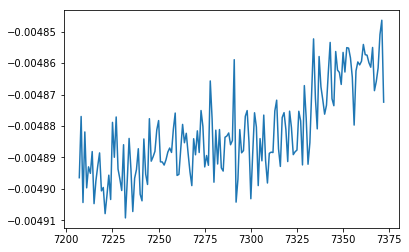

In [136]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

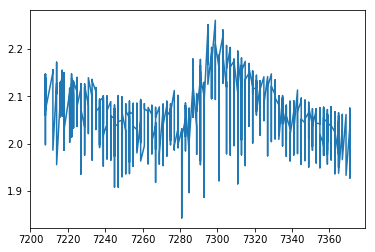

In [137]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

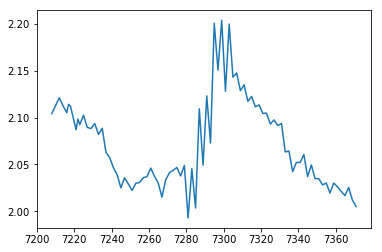

In [138]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

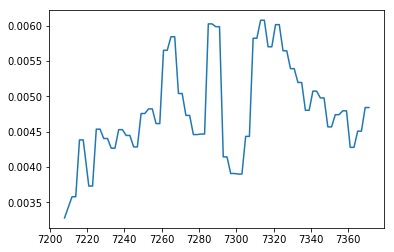

In [139]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [140]:
background_mean = df_mean(background)

# Outlier rejection

In [199]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [200]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [201]:
column = "124/120"
sample = "NIST 200ppb"

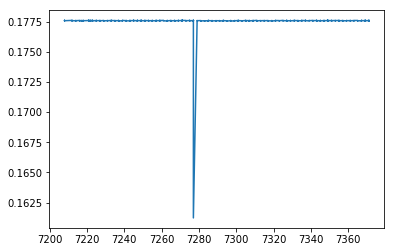

In [202]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [203]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [204]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-04-27 16:22:00,NIST 200ppb,2,1,7208,0.029824,0.020197,0.010357,0.445992,0.235327,0.742935,0.263510,0.142104,0.177589
2017-04-27 16:22:00,NIST 200ppb,2,2,7208,0.029826,0.020190,0.010357,0.446005,0.235325,0.742935,0.263526,0.142109,0.177605
2017-04-27 16:22:00,NIST 200ppb,2,3,7208,0.029826,0.020190,0.010356,0.446024,0.235338,NaN,0.263513,0.142099,0.177576
2017-04-27 16:22:00,NIST 200ppb,2,4,7208,0.029824,0.020192,0.010359,0.446003,0.235325,NaN,0.263516,0.142105,0.177592
2017-04-27 16:22:00,NIST 200ppb,2,5,7208,0.029822,0.020191,0.010358,0.446004,0.235326,NaN,0.263512,0.142098,0.177578
2017-04-27 16:22:00,NIST 200ppb,2,6,7208,0.029827,0.020193,0.010356,0.446005,0.235344,NaN,0.263507,0.142096,0.177588
2017-04-27 16:22:00,NIST 200ppb,2,7,7208,0.029825,0.020194,0.010358,0.446017,0.235329,0.742935,0.263513,0.142096,0.177587
2017-04-27 16:22:00,NIST 200ppb,2,8,7208,0.029830,0.020192,0.010360,0.446028,0.235342,NaN,0.263505,0.142097,0.177578
2017-04-27 16:22:00,NIST 200ppb,2,9,7208,0.029826,0.020187,0.010360,0.446023,0.235335,NaN,0.263527,0.142099,0.177593


In [205]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
7212        2017-04-27 17:13:00    0.187115
7213        2017-04-27 17:28:00    0.187079
7230        2017-04-27 22:23:00    0.187192
7241        2017-04-28 00:51:00    0.187143
7245        2017-04-28 01:45:00    0.187209
7247        2017-04-28 02:14:00    0.187191
7267        2017-04-28 06:47:00    0.187142
7271        2017-04-28 07:41:00    0.187202
7273        2017-04-28 08:07:00    0.187163
            2017-04-28 08:07:00    0.187163
7277        2017-04-28 09:02:00    0.169890
7281        2017-04-28 09:57:00    0.187165
7283        2017-04-28 10:25:00    0.187149
7317        2017-04-28 18:07:00    0.187159
            2017-04-28 18:07:00    0.187157
7321        2017-04-28 19:01:00    0.187120
7363        2017-04-29 04:37:00    0.187252
            2017-04-29 04:37:00    0.187252
7369        2017-04-29 05:56:00    0.187264
            2017-04-29 05:56:00    0.187265
7371        2017-04-29 06:25:00    0.187264
Name: 124/120, dtype: float64

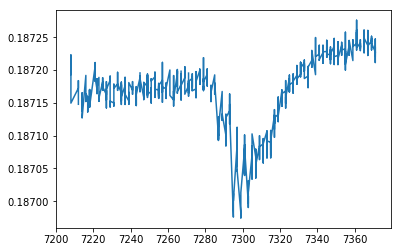

In [206]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [207]:
df[df["Sample"] == sample][column].std()

5.5358054743187076e-05

In [208]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

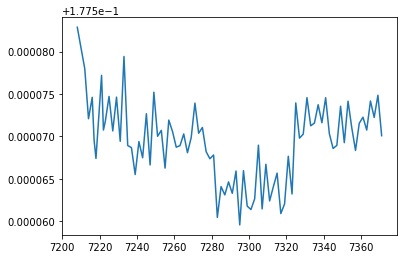

In [209]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [210]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-04-27 16:22:00,7208,NIST 200ppb,0.029826,0.020191,0.010359,0.446012,0.235334,0.742935,0.263509,0.142099,0.177583
2017-04-27 16:48:00,7210,NIST 350ppb,0.029827,0.020193,0.010361,0.446012,0.235332,0.742935,0.263502,0.142098,0.177573
2017-04-27 17:13:00,7212,NIST 200ppb,0.029828,0.020192,0.010360,0.446015,0.235335,0.742935,0.263501,0.142098,0.177578
2017-04-27 17:28:00,7213,NIST 350ppb,0.029826,0.020191,0.010361,0.446008,0.235330,0.742935,0.263499,0.142097,0.177575
2017-04-27 17:42:00,7214,NIST 200ppb,0.029828,0.020193,0.010361,0.446008,0.235330,0.742935,0.263499,0.142097,0.177572
2017-04-27 18:08:00,7216,NIST 200ppb,0.029826,0.020189,0.010361,0.446009,0.235329,0.742935,0.263496,0.142097,0.177575
2017-04-27 18:22:00,7217,NIST 200ppb,0.029826,0.020191,0.010359,0.446005,0.235330,0.742935,0.263498,0.142096,0.177570
2017-04-27 18:37:00,7218,NIST 200ppb,0.029828,0.020190,0.010360,0.446012,0.235332,0.742935,0.263493,0.142095,0.177567
2017-04-27 20:19:00,7221,NIST 200ppb,0.029829,0.020192,0.010361,0.446012,0.235331,0.742935,0.263501,0.142098,0.177577


In [211]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [212]:
drop_sum = []

In [213]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [214]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [215]:
data_mean_int_sum

112/120                       114/120  \
                               mean           SD2 count      mean   
Sample                                                              
Allende bomb 2_1+2_2       0.029826           NaN     1  0.020194   
GRA06100 bomb 1_2          0.029822           NaN     1  0.020193   
Indarch bomb 1_2           0.029828           NaN     1  0.020196   
J.W. bomb 1_1              0.029826           NaN     1  0.020192   
NIST 200ppb                0.029828  3.200321e-06    83  0.020193   
NIST 200ppb + 0.005ppb U   0.029828  1.431271e-06     2  0.020193   
NIST 200ppb + 0.015ppb U   0.029829  1.431748e-06     2  0.020194   
NIST 200ppb + 0.030ppb Cd  0.029829  2.201532e-06     2  0.020195   
NIST 200ppb + 0.04ppb Cd   0.029828  2.808121e-06     2  0.020196   
NIST 200ppb + 0.100ppb Zr  0.029828  9.650229e-07     2  0.020192   
NIST 200ppb + 0.150ppb Rh  0.029828  5.981582e-07     2  0.020192   
NIST 200ppb + 0.300ppb Ru  0.029828  7.780782e-07     2  0.020193   
NIST 200ppb + 0.50ppb Pd   0.029828  1.089188e-06     2  0.020192   
NIST 200ppb + 0.628ppb Te  0.029830  2.419658e-06     2  0.020194   
NIST 200ppb + 2ppb Mo      0.029827  3.463894e-06     2  0.020192   
NIST 200ppb + ME           0.029828  2.826655e-06     2  0.020195   
NIST 350ppb                0.029827  2.361960e-06     9  0.020193   
Nod P1 1911                0.029827           NaN     1  0.020195   
ZH09-05 23.3_1_8           0.029824           NaN     1  0.020192   
ZH09-05 23.3_3b_3 Aliq.3   0.029826           NaN     1  0.020196   
Zh09-05 23.3_3b_2          0.029827           NaN     1  0.020195   

                                                115/120                      \
                                    SD2 count      mean           SD2 count   
Sample                                                                        
Allende bomb 2_1+2_2                NaN     1  0.010361           NaN     1   
GRA06100 bomb 1_2                   NaN     1  0.010360           NaN     1   
Indarch bomb 1_2                    NaN     1  0.010361           NaN     1   
J.W. bomb 1_1                       NaN     1  0.010359           NaN     1   
NIST 200ppb                3.571462e-06    83  0.010362  1.938158e-06    83   
NIST 200ppb + 0.005ppb U   2.955825e-06     2  0.010361  2.362754e-06     2   
NIST 200ppb + 0.015ppb U   1.235237e-06     2  0.010362  7.671696e-07     2   
NIST 200ppb + 0.030ppb Cd  5.265434e-06     2  0.010362  1.595784e-06     2   
NIST 200ppb + 0.04ppb Cd   1.543295e-06     2  0.010362  2.061670e-06     2   
NIST 200ppb + 0.100ppb Zr  3.400909e-06     2  0.010361  4.915100e-08     2   
NIST 200ppb + 0.150ppb Rh  5.976262e-07     2  0.010361  9.767820e-07     2   
NIST 200ppb + 0.300ppb Ru  5.425939e-06     2  0.010362  2.747316e-06     2   
NIST 200ppb + 0.50ppb Pd   3.323891e-06     2  0.010362  8.420832e-07     2   
NIST 200ppb + 0.628ppb Te  2.183028e-06     2  0.010363  2.000042e-06     2   
NIST 200ppb + 2ppb Mo      9.135465e-06     2  0.010361  4.497263e-07     2   
NIST 200ppb + ME           2.057623e-06     2  0.010361  8.034245e-07     2   
NIST 350ppb                2.343430e-06     9  0.010362  1.169155e-06     9   
Nod P1 1911                         NaN     1  0.010362           NaN     1   
ZH09-05 23.3_1_8                    NaN     1  0.010362           NaN     1   
ZH09-05 23.3_3b_3 Aliq.3            NaN     1  0.010361           NaN     1   
Zh09-05 23.3_3b_2                   NaN     1  0.010361           NaN     1   

                            116/120  ...  118/120   119/120                \
                               mean  ...    count      mean           SD2   
Sample                               ...                                    
Allende bomb 2_1+2_2       0.446004  ...        1  0.263489           NaN   
GRA06100 bomb 1_2          0.445996  ...        1  0.263487           NaN   
Indarch bomb 1_2           0.446001  ...        1  0.263488           NaN   
J.W. bomb 1_

In [216]:
date_list = [pd.Timestamp("2017-04-27 20:19:00"), 
             pd.Timestamp("2017-04-28 17:41:00"), 
             pd.Timestamp("2017-04-28 22:40:00"), 
             pd.Timestamp("2017-04-28 23:35:00")]


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [217]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-04-27 16:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2017-04-27 16:48:00,0.000000,0.090284,0.617134,1.433558,-0.035930,-0.105717,-1.110223e-12,-0.118334,-0.083241,-0.411774,NIST 350ppb
2017-04-27 17:13:00,1.386770,0.425520,0.299199,0.206840,0.114816,0.113119,-1.110223e-12,-0.102747,0.008080,0.028368,NIST 200ppb
2017-04-27 17:28:00,0.000000,-0.617673,-0.854913,0.283562,-0.080834,-0.096352,0.000000e+00,-0.035411,-0.024715,0.001118,NIST 350ppb
2017-04-27 17:42:00,0.000000,0.288053,0.919471,0.136262,-0.098403,-0.071962,2.220446e-12,0.010900,-0.048208,-0.237116,NIST 200ppb
2017-04-27 18:08:00,0.692953,-0.340644,-1.113850,1.600137,0.066108,-0.027765,0.000000e+00,-0.102014,0.056831,0.213690,NIST 200ppb
2017-04-27 18:22:00,0.000000,-0.309270,0.477817,-2.113665,-0.128598,-0.037928,-1.110223e-12,0.149868,-0.003238,-0.082243,NIST 200ppb
2017-04-27 18:37:00,-2.077706,-0.011839,-0.684525,0.282460,0.011695,-0.017353,-1.110223e-12,-0.173647,-0.054831,-0.154700,NIST 200ppb
2017-04-27 20:34:00,2.077418,0.649046,0.862449,0.048293,0.131162,0.102142,2.220446e-12,0.115072,-0.007431,0.065569,NIST 200ppb


In [218]:

date_list = []

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [219]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [220]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [221]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-04-27 16:48:00,7210,0.090284,0.617134,1.433558,-0.035930,-0.105717,-1.110223e-12,-0.118334,-0.083241,-0.411774,NIST 350ppb
2017-04-27 17:13:00,7212,0.425520,0.299199,0.206840,0.114816,0.113119,-1.110223e-12,-0.102747,0.008080,0.028368,NIST 200ppb
2017-04-27 17:28:00,7213,-0.617673,-0.854913,0.283562,-0.080834,-0.096352,0.000000e+00,-0.035411,-0.024715,0.001118,NIST 350ppb
2017-04-27 17:42:00,7214,0.288053,0.919471,0.136262,-0.098403,-0.071962,2.220446e-12,0.010900,-0.048208,-0.237116,NIST 200ppb
2017-04-27 18:08:00,7216,-0.340644,-1.113850,1.600137,0.066108,-0.027765,0.000000e+00,-0.102014,0.056831,0.213690,NIST 200ppb
2017-04-27 18:22:00,7217,-0.309270,0.477817,-2.113665,-0.128598,-0.037928,-1.110223e-12,0.149868,-0.003238,-0.082243,NIST 200ppb
2017-04-27 18:37:00,7218,-0.011839,-0.684525,0.282460,0.011695,-0.017353,-1.110223e-12,-0.173647,-0.054831,-0.154700,NIST 200ppb
2017-04-27 20:34:00,7222,0.649046,0.862449,0.048293,0.131162,0.102142,2.220446e-12,0.115072,-0.007431,0.065569,NIST 200ppb
2017-04-27 20:48:00,7223,-0.085235,0.250427,0.508549,-0.087134,-0.032029,0.000000e+00,-0.087200,0.032399,-0.054093,NIST 200ppb


In [222]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [223]:
epsilon_sum_all

112/120              114/120              115/120  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
Allende bomb 2_1+2_2       -1.011    NaN     1  -0.459    NaN     1  -0.384   
GRA06100 bomb 1_2          -1.387    NaN     1  -0.477    NaN     1  -1.704   
Indarch bomb 1_2            0.413    NaN     1   0.782    NaN     1  -1.717   
J.W. bomb 1_1               0.106    NaN     1   0.213    NaN     1  -2.737   
NIST 200ppb                 0.001  1.068    77  -0.001  1.626    77   0.002   
NIST 200ppb + 0.005ppb U    0.226  2.340     2  -0.071  2.431     2  -0.332   
NIST 200ppb + 0.015ppb U    0.145  0.665     2   0.375  0.848     2   0.095   
NIST 200ppb + 0.030ppb Cd  -0.278  0.818     2   0.217  1.438     2   0.107   
NIST 200ppb + 0.04ppb Cd   -0.389  1.625     2   1.315  2.363     2  -0.178   
NIST 200ppb + 0.100ppb Zr   0.163  0.045     2  -0.344  0.177     2   0.007   
NIST 200ppb + 0.150ppb Rh   0.184  0.378     2  -0.441  0.246     2  -0.891   
NIST 200ppb + 0.300ppb Ru   0.217  0.800     2   0.384  1.623     2  -0.206   
NIST 200ppb + 0.50ppb Pd   -0.356  0.717     2  -0.225  0.357     2   0.074   
NIST 200ppb + 0.628ppb Te   0.508  0.772     2   1.079  1.895     2   0.491   
NIST 200ppb + 2ppb Mo      -0.138  0.931     2   0.344  1.765     2  -0.245   
NIST 200ppb + ME            0.133  1.013     2   1.642  0.591     2  -0.101   
NIST 350ppb                -0.090  0.944     9  -0.007  1.174     9   0.086   
Nod P1 1911                -0.329    NaN     1   1.260    NaN     1   0.532   
ZH09-05 23.3_1_8           -0.876    NaN     1  -0.345    NaN     1  -0.169   
ZH09-05 23.3_3b_3 Aliq.3   -0.974    NaN     1   0.487    NaN     1  -1.789   
Zh09-05 23.3_3b_2          -0.559    NaN     1   0.523    NaN     1  -0.954   

                                       116/120  ...  118/120 119/120         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
Allende bomb 2_1+2_2         NaN     1  -0.059  ...        1   0.073    NaN   
GRA06100 bomb 1_2            NaN     1  -0.239  ...        1  -0.086    NaN   
Indarch bomb 1_2             NaN     1  -0.197  ...        1   0.013    NaN   
J.W. bomb 1_1                NaN     1   0.121  ...        1  -0.016    NaN   
NIST 200ppb                1.728    77  -0.001  ...       77  -0.002  0.179   
NIST 200ppb + 0.005ppb U   0.249     2  -0.003  ...        2   0.217  0.104   
NIST 200ppb + 0.015ppb U   1.520     2   0.069  ...        2   0.635  0.117   
NIST 200ppb + 0.030ppb Cd  2.321     2   0.017  ...        2   0.063  0.145   
NIST 200ppb + 0.04ppb Cd   1.116     2  -0.031  ...        2  -0.034  0.154   
NIST 200ppb + 0.100ppb Zr  2.155     2   0.115  ...        2  -0.079  0.003   
NIST 200ppb + 0.150ppb Rh  0.073     2   0.076  ...        2   0.045  0.264   
NIST 200ppb + 0.300ppb Ru  1.069     2  -0.026  ...        2   0.003  0.243   
NIST 200ppb + 0.50ppb Pd   1.587     2  -0.006  ...        2  -0.016  0.066   
NIST 200ppb + 0.628ppb Te  2.153     2   0.071  ...        2   0.006  0.158   
NIST 200ppb + 2ppb Mo      0.119     2  -0.073  ...        2   0.000  0.057   
NIST 200ppb + ME           2.050     2  -0.000  ...        2   0.224  0.061   
NIST 350ppb                1.620     9  -0.050  ...        9  -0.014  0.213   
Nod P1 1911                  NaN     1  -0.209  ...        1   0.389    NaN   
ZH09-05 23.3_1_8             NaN     1  -0.034  ...        1  -0.132    NaN   
ZH09-05 23.3_3b_3 Aliq.3     NaN     1   0.089  ...        1  -0.013    NaN   
Zh09-05 23.3_3b_2            NaN     1   0.028  ...        1   0.006    NaN   

                                122/120              124/120               
                          count    mean    SD2 count    mean    SD2 count  
Sample                                                                     
Alle

In [131]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

SyntaxError: invalid syntax (<ipython-input-131-46d5f69f4564>, line 6)

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [166]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [167]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [224]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [225]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [226]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [227]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')